# Setup-import libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import xgboost as xgb

## Define Utilities

In [8]:
def plot_model_performance(y_pred, y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    columns = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    data = [accuracy, precision, recall, f1]
    df_metrics = pd.DataFrame(data=data, index=columns, columns=['metrics'])

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot for metrics
    axes[0].bar(df_metrics.index, df_metrics['metrics'], color='grey')
    axes[0].set_xlabel('Metrics', fontsize=14)
    axes[0].set_ylabel('Scores', fontsize=14)
    axes[0].set_title('Model Performance Metrics', fontsize=20, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for bar in axes[0].patches:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    # Confusion matrix
    dt_cf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(dt_cf).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Data loading 


In [9]:
apple_stock = yf.download('AAPL') 
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock = apple_stock[apple_stock.index > '2010-01-01']
apple_stock.index = pd.to_datetime(apple_stock.index)

[*********************100%%**********************]  1 of 1 completed


In [17]:
# Calculate daily returns
apple_stock['Return'] = apple_stock['Adj Close'].pct_change()

# Drop missing values
apple_stock.dropna(inplace=True)

# Features: Using previous day's return and other technical indicators as features
apple_stock['Lag1'] = apple_stock['Return'].shift(1)
apple_stock['Lag2'] = apple_stock['Return'].shift(2)
apple_stock['SMA10'] = apple_stock['Adj Close'].rolling(window=10).mean()
apple_stock['SMA50'] = apple_stock['Adj Close'].rolling(window=50).mean()
apple_stock['SMA10'] = apple_stock['SMA10'].shift(1)
apple_stock['SMA50'] = apple_stock['SMA50'].shift(1)
apple_stock.dropna(inplace=True)

C:\Users\12436\AppData\Local\Temp\ipykernel_7768\1553970756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock['Return'] = apple_stock['Adj Close'].pct_change()
C:\Users\12436\AppData\Local\Temp\ipykernel_7768\1553970756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock.dropna(inplace=True)
C:\Users\12436\AppData\Local\Temp\ipykernel_7768\1553970756.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

## Train-test split

In [19]:
train = apple_stock[apple_stock.index <= '2024-01-01']
test = apple_stock[apple_stock.index > '2024-01-01']
print(f'Train set size: {train.shape}')
print(f'Test set size: {test.shape}')

Train set size: (3371, 7)
Test set size: (127, 7)


In [20]:
features = ['Lag1', 'Lag2', 'SMA10', 'SMA50']
target = 'Return'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
# !pip install xgboost

In [79]:
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.01, max_depth=7, n_estimators=200)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [80]:
y_pred = xgb_model.predict(X_test)


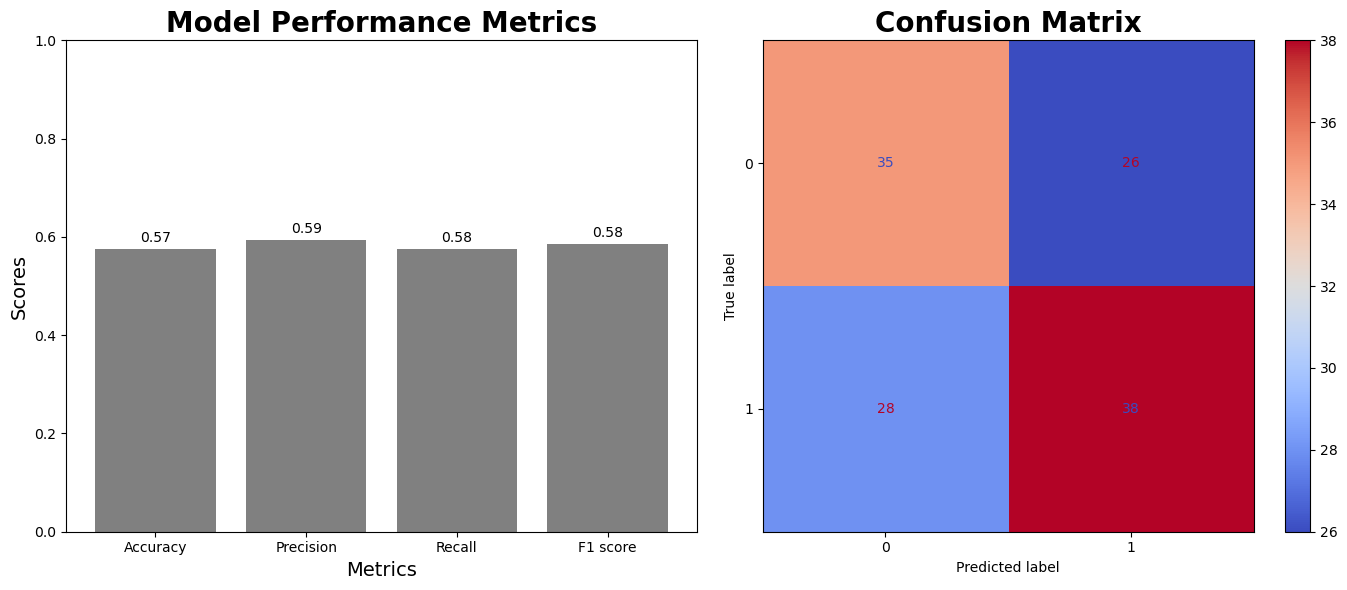

0.59375

In [81]:
df_xgboost = pd.DataFrame({
    'Actual data': y_test,
    'predicted data': y_pred
}, index=y_test.index)
df_xgboost['actual binary'] = np.where(df_xgboost['Actual data']>0,1,0)
df_xgboost['predicted binary'] = np.where(df_xgboost['predicted data']>0,1,0)

plot_model_performance(df_xgboost['predicted binary'], df_xgboost['actual binary'])
precision = precision_score(df_xgboost['actual binary'], df_xgboost['predicted binary'])
precision

In [82]:
precision_lst =[]
combination_lst = []

n_estimators = [10, 50, 100, 200, 300, 400]
learning_rate = [0.005, 0.01, 0.05, 0.1]
max_depth = [3, 5, 7, 9, 11]


for a in n_estimators:
    for b in learning_rate:
        for c in max_depth:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=b, max_depth=c, n_estimators=a)
            xgb_model.fit(X_train, y_train)

            y_pred = xgb_model.predict(X_test)
            df_xgboost = pd.DataFrame({
                                        'Actual data': y_test,
                                        'predicted data': y_pred
                                    }, index=y_test.index)
            df_xgboost['actual binary'] = np.where(df_xgboost['Actual data']>0,1,0)
            df_xgboost['predicted binary'] = np.where(df_xgboost['predicted data']>0,1,0)
            precision = precision_score(df_xgboost['actual binary'], df_xgboost['predicted binary'])
            precision_lst.append(precision)
            combination_lst.append([a,b,c])



,0,combination
63,0.602941,"[200, 0.005, 9]"


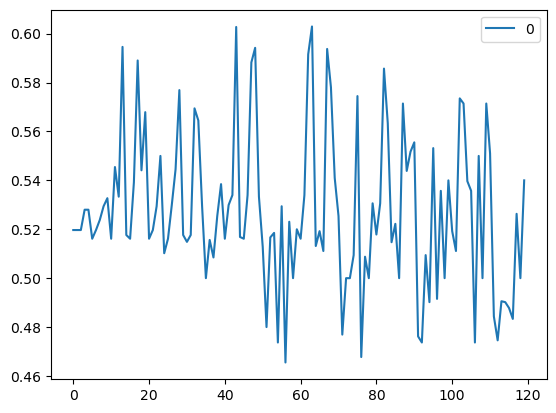

In [83]:
df = pd.DataFrame(data=precision_lst)
df.plot()
df['combination'] = combination_lst
df[df[0] == df[0].max()]

# Use the grid search to check the performance of the model

In [6]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Download historical data for Apple stock
apple_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')

# Calculate daily returns
apple_data['Return'] = apple_data['Adj Close'].pct_change()

# Drop missing values
apple_data.dropna(inplace=True)

# Features: Using previous day's return and other technical indicators as features
apple_data['Lag1'] = apple_data['Return'].shift(1)
apple_data['Lag2'] = apple_data['Return'].shift(2)
apple_data['SMA10'] = apple_data['Adj Close'].rolling(window=10).mean()
apple_data['SMA50'] = apple_data['Adj Close'].rolling(window=50).mean()

# Define the functions for technical indicators
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    
    return macd - signal_line

# Add technical indicators
apple_data['RSI'] = compute_rsi(apple_data['Adj Close'], window=14)
apple_data['MACD'] = compute_macd(apple_data['Adj Close'])

# Drop rows with NaN values generated by indicators
apple_data.dropna(inplace=True)

# Prepare data for training
features = ['Lag1', 'Lag2', 'SMA10', 'SMA50', 'RSI', 'MACD']
target = 'Return'

X = apple_data[features]
y = apple_data[target]

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=tscv, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

# Train the best model
best_model = grid_search.best_estimator_

# Predict and evaluate the model using the last fold as a test set
last_train_index = list(tscv.split(X))[-1][0][-1]
X_train, X_test = X.iloc[:last_train_index+1], X.iloc[last_train_index+1:]
y_train, y_test = y.iloc[:last_train_index+1], y.iloc[last_train_index+1:]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Predict future returns
new_data = yf.download('AAPL', start='2023-01-02', end='2023-07-01')

# Prepare new data
new_data['Return'] = new_data['Adj Close'].pct_change()
new_data['Lag1'] = new_data['Return'].shift(1)
new_data['Lag2'] = new_data['Return'].shift(2)
new_data['SMA10'] = new_data['Adj Close'].rolling(window=10).mean()
new_data['SMA50'] = new_data['Adj Close'].rolling(window=50).mean()
new_data['RSI'] = compute_rsi(new_data['Adj Close'], window=14)
new_data['MACD'] = compute_macd(new_data['Adj Close'])
new_data.dropna(inplace=True)

# Predict returns for new data
X_new = new_data[features]
predicted_returns = best_model.predict(X_new)

# Add predictions to the new data frame
new_data['Predicted_Return'] = predicted_returns

# Display the results
print(new_data[['Predicted_Return']])

[*********************100%%**********************]  1 of 1 completed


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: -0.0003132810077197517
Mean Squared Error: 0.0003471259923703162
R-squared: 0.06336185179906473


[*********************100%%**********************]  1 of 1 completed

            Predicted_Return
Date                        
2023-03-15         -0.002881
2023-03-16          0.000640
2023-03-17          0.001045
2023-03-20          0.001835
2023-03-21          0.002955
...                      ...
2023-06-26         -0.000334
2023-06-27          0.002370
2023-06-28          0.002385
2023-06-29          0.002520
2023-06-30          0.002346

[75 rows x 1 columns]
